<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/csivava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Csivava vagy muffin?

Számos kép kering az interneten, melyen az ember is nehezen tud megkülönböztetni egy csivavát egy áfonyás maffintól. Nézzük meg, hogy a konvolúciós neurális hálózat hogyan boldogul ezzel a feladattal.

Összegyűjtöttünk 26 csivava és 26 áfonyás maffin képet az internetről.

A kép letöltése.

In [23]:
!wget -q -O cs_ma.jpg https://github.com/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/data/cs_ma.jpg?raw=true

##Képek előkészítése

Az 52 darab 100x100 pixeles, csivava illetve maffin képet egyetlen képfájlba raktuk össze, 13 sorban és négy oszlopban.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

Nézzük meg a képet!

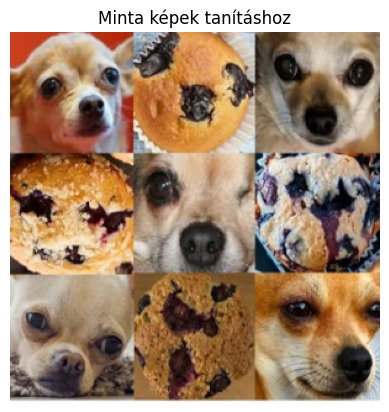

In [22]:
img = imread('cs_ma.jpg')
plt.axis("off")
plt.imshow(img, cmap='gray')
_ = plt.title("Minta képek tanításhoz")

##Előkészítés

A letöltött egy nagy képet szét kell darabolnunk és a kialakított kis képekhez a címkéket is elő kell állítanunk.

In [4]:
image_size = 50                 # a kis képek mérete (négyzetes), pixel
sample_start = 0                # ettől a sortól kell feldolgozni a mintákat
sample_rows = 13                # eddig a sorig kell feldolgozni a mintákat
sample_cols = 4                 # ennyi minta van egy sorban
sample_num = sample_rows * sample_cols  # összes minta száma
size = 100                      # minták szkennelt mérete, pixel
border = 0                      # vágási margó, pixel
labels = ["csivava", "maffin"]  # cimke nevek, 0-csivava, 1-maffin)
num_classes = len(labels)
lab = np.array([[1, 0, 1, 0],
                [0, 1, 0, 1],
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [1, 0, 1, 0],
                [0, 1, 0, 1],
                [1, 0, 1, 0]
                ])

In [5]:
# tömbök létrehozása a bemenő adatoknak és a címkéknek
X = np.zeros((sample_num, image_size, image_size, 3, 1), dtype='float32')
y = lab.flatten()
# kis képek létrehozása
k = 0
for i in range(sample_start, sample_start + sample_rows):     # minden sorra
    pixel_top = i * size + border                             # sor felső pixele
    pixel_bot = (i + 1) * size - border                       # sor alsó pixele
    for j in range(sample_cols):                              # minden oszlopra
        pixel_left = j * size + border                        # oszlop bal széle pixel
        pixel_righ = (j + 1) * size - border                  # oszlop jobb széle pixel
        sub_img = img[pixel_top:pixel_bot,pixel_left:pixel_righ]
        # felbontás lecsökkentése
        X[k] = np.expand_dims(resize(sub_img, (image_size, image_size, 3)), -1)
        k += 1

Az előkészítés végén ellenőrizzük a kis képeket és a címkéket!

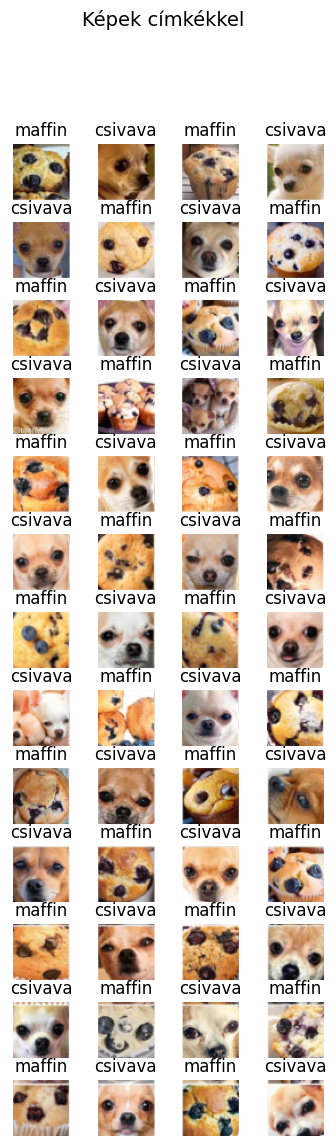

In [6]:
fig, ax = plt.subplots(sample_rows, sample_cols, figsize=(sample_cols, sample_rows))
fig.suptitle('Képek címkékkel', fontsize=14)
ax = ax.ravel()
for i in range(sample_num):
    ax[i].imshow(X[i,:,:,:,0])
    ax[i].set_title(labels[int(y[i])])
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

##Tanítás

A tanítás soran a felcímkézett képeket tanító (80%) és teszt (20%) részre bontjuk szét. Emellett előkészítjük a Keras használatához.

In [7]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.metrics import binary_accuracy

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
y_orig_train = y_train.copy()
y_train = to_categorical(y_train, num_classes)      # címkék szükséges átalakítása Kerashoz
y_orig_test = y_test.copy()
y_test = to_categorical(y_test, num_classes)
filter_size = 3                                     # 3 x 3 konvolúciós szűrőket használunk

Egy egyszerű CNN modell hozunk létre.

In [9]:
model = Sequential()
# 3 x 3 konvolúciós szűrő
model.add(Conv2D(16, (filter_size, filter_size), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D((2, 2)))                 # kép méret felére csökkentése
model.add(Flatten())                            # kép vektorrá alakítása
model.add(Dropout(0.5))                         # súlyok véletlenszerű kihagyása 50%-ban
model.add(Dense(2, activation='softmax'))       # kimeneti réteg
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)     # hiper paraméterek
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dropout (Dropout)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 2)                 18434     
                                                                 
Total params: 18882 (73.76 KB)
Trainable params: 18882 (73.76 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

A tanítást 30 iterációs lépésben végezzük el.

In [12]:
epochs = 15             # iterációk száma
batch_size = 6         # egyidejűleg feldolgozott minták száma
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/15
7/7 [==============================] - 1s 95ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1708 - val_accuracy: 0.8182
Epoch 2/15
7/7 [==============================] - 0s 38ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1685 - val_accuracy: 0.8182
Epoch 3/15
7/7 [==============================] - 0s 42ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1638 - val_accuracy: 0.8182
Epoch 4/15
7/7 [==============================] - 0s 37ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1626 - val_accuracy: 0.8182
Epoch 5/15
7/7 [==============================] - 0s 29ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1626 - val_accuracy: 0.8182
Epoch 6/15
7/7 [==============================] - 0s 21ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1626 - val_accuracy: 0.8182
Epoch 7/15
7/7 [==============================] - 0s 17ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.1552 - val_accuracy: 0.8182
Epoch 8/15
7/7 [===========

Nézzük meg a tanítás folyamatát!

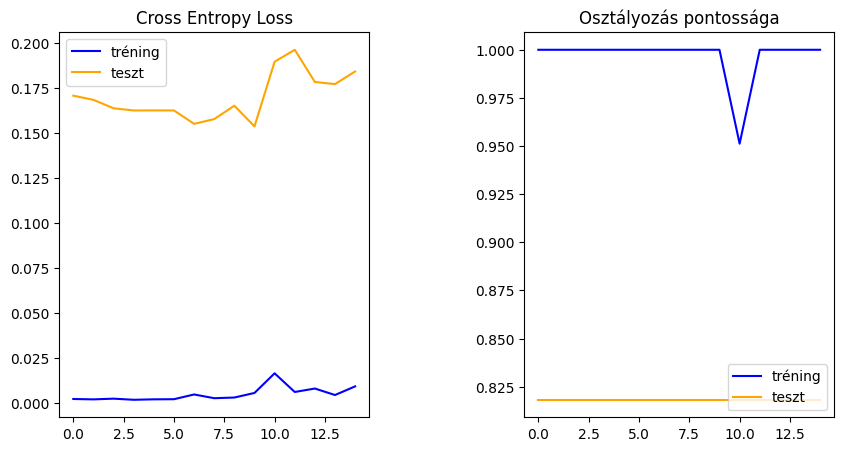

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Cross Entropy Loss')
ax[0].plot(history.history['loss'], color='blue', label='tréning')
ax[0].plot(history.history['val_loss'], color='orange', label='teszt')
ax[0].legend()
# pontosság ábrázolása
ax[1].set_title('Osztályozás pontossága')
ax[1].plot(history.history['accuracy'], color='blue', label='tréning')
ax[1].plot(history.history['val_accuracy'], color='orange', label='teszt')
ax[1].legend(loc=4)
plt.subplots_adjust(wspace=0.5)

In [14]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
print(f"Pontosság teszt  adatokra: {np.sum(binary_accuracy(y_test, y_pred_test, threshold=0.5)) / y_pred_test.shape[0]:.1%}")
print(f"Pontosság tanító adatokra: {np.sum(binary_accuracy(y_train, y_pred_train, threshold=0.5)) / y_pred_train.shape[0]:.1%}")

2/2 [==============================] - 0s 8ms/step
Pontosság teszt  adatokra: 81.8%
Pontosság tanító adatokra: 100.0%


Nézzük meg, melyik teszt képet sikerült illetve nem sikerült jól besorolni. Piros színnel írjuk a fel a téves besorolásokat.

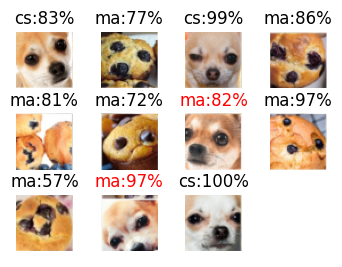

In [15]:
pred_test_classes = np.argmax(y_pred_test, axis=1)
fig, ax = plt.subplots(X_test.shape[0]//sample_cols+1, sample_cols, figsize=(sample_cols, X_test.shape[0]//sample_cols+1))
#fig.suptitle('Teszt képek', fontsize=14)
ax = ax.ravel()
for a in ax:
    a.axis("off")       # turn off axis on all subplots

for i in range(X_test.shape[0]):
    cls = pred_test_classes[i]     # 0/1
    val = y_pred_test[i, cls]
    ax[i].imshow(X_test[i,:,:,:,0])
    color= 'black' if int(cls+0.5) == y_orig_test[i] else 'red'
    ax[i].set_title(f"{labels[int(cls)][:2]}:{val:.0%}", c=color)
plt.subplots_adjust(wspace=0.5)

A képek feletti százalékos érték jelzi a besorolás valószínűségét. Sok esetben közel vagyünk az 50%-hoz. A modellünk nem túl magabiztosan, de zömében jól sorolta be az ellenőrző képeket.

Ismételjük meg a tanítástól a folyamatot! Vegye észre, hogy a megismételt futtatás eredménye nem azonos az előzővel, mivel véletlenszámoktól függ a tanítási folyamat.

Végül nézzük meg a modellünk teljesítményét eddig nem látott fényképeken.

In [25]:
!wget -q -O cs_ma_test.jpg https://github.com/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/data/cs_ma_test.jpg?raw=true
test_rows = 3
test_cols = 3
test_num = test_cols * test_rows
imgt = imread('cs_ma_test.jpg')

1/1 [==============================] - 0s 33ms/step


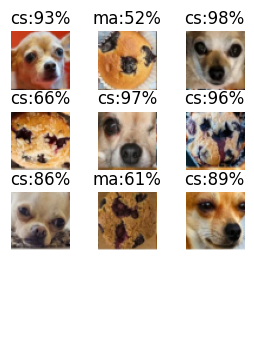

In [26]:
# tömbök létrehozása a bemenő adatoknak
XX = np.zeros((9, image_size, image_size, 3, 1), dtype='float32')
# kis képek létrehozása
k = 0
for i in range(test_rows):     # minden sorra
    pixel_top = i * size + border                             # sor felső pixele
    pixel_bot = (i + 1) * size - border                       # sor alsó pixele
    for j in range(test_cols):                              # minden oszlopra
        pixel_left = j * size + border                        # oszlop bal széle pixel
        pixel_righ = (j + 1) * size - border                  # oszlop jobb széle pixel
        sub_img = imgt[pixel_top:pixel_bot,pixel_left:pixel_righ]
        # felbontás lecsökkentése
        XX[k] = np.expand_dims(resize(sub_img, (image_size, image_size, 3)), -1)
        k += 1
yy = model.predict(XX)
yy_classes = np.argmax(yy, axis=1)
fig, ax = plt.subplots(XX.shape[0]//test_cols+1, test_cols, figsize=(test_cols, XX.shape[0]//test_cols+1))
ax = ax.ravel()
for a in ax:
    a.axis("off")       # turn off axis on all subplots

for i in range(XX.shape[0]):
    cls = yy_classes[i]     # 0/1
    val = yy[i, cls]
    ax[i].imshow(XX[i,:,:,:,0])
    color= 'black'
    ax[i].set_title(f"{labels[int(cls)][:2]}:{val:.0%}", c=color)
plt.subplots_adjust(wspace=0.5)

Ellenőrizze, hogy jó válaszokat a modellünkből!